**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
from sklearn.linear_model import LinearRegression

seaborn.set_context('talk')

In [ ]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

### Columnas relevantes
Creemos que las columnas relevantes a utilizar son: 
* profile_years_experience
* salary_monthly_NETO
* tools_programming_languages
* salary_in_usd





In [ ]:
df.head()

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.0,Bruto,Full-Time,53000.0,43000.0,NaN,1,1,No,No recibo bono,No,0.0,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.0,Bruto,Full-Time,79000.0,63000.0,NaN,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.0,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,NaN,NaN,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Infosec,"Linux, VMWare",Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,Windows,iOS,No,0.0,Porcentaje de mi sueldo,Full-Time,160000.0,127000.0,NaN,3,3,Un sueldo,Performance individual,No,0.0,0,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN
3,Hombre,39,Argentina,Corrientes,15.0,15.0,13.0,5,Posgrado,Incompleto,Licenciatura en Sistemas,UNNE Universidad Nacional del Nordeste,"Sí, de forma particular, Sí, los pagó un emple...",Sí,Sí,SysAdmin / DevOps / SRE,"Docker, Linux, OpenStack, VMWare, Windows Server","Bash/Shell, C, CSS, HTML, Java, Javascript, PH...","jQuery, WordPress","Microsoft SQL Server, MySQL",PHPUnit,"Eclipse, Visual Studio Code",GNU/Linux,Android,"Sí, pasiva",0.0,Bruto,Full-Time,130000.0,102000.0,NaN,3,1,No,No recibo bono,No,0.0,0,En mi trabajo actual,Heterosexual,NaN,NaN,501-1000,Otras industrias,7,6,"Abono de celular, Capacitaciones y/o cursos, C...",NaN
4,Hombre,32,Argentina,Ciudad Autónoma de Buenos Aires,9.0,6.0,6.0,0,Universitario,En curso,Licenciatura en Ciencias dela Computación,UBA - Universidad de Buenos Aires,No,No,Sí,Developer,Amazon Web Services,"CSS, HTML, Javascript, SQL, TypeScript","Angular, Node.js","Amazon DynamoDB, MongoDB, MySQL",Jest,Vim,macOS,Android,No,0.0,Porcentaje de mi sueldo,Full-Time,140000.0,106000.0,NaN,1,1,Menos de un sueldo,Performance individual,No,0.0,0,Jamás,Heterosexual,NaN,NaN,11-50,Servicios / Consultoría de Software / Digital,6,6,"Clases de idiomas, Horarios flexibles, Vacacio...",NaN


### Filtrado de datos
#### Años de experiencia
Para ver los máximos valores 


In [ ]:
##missing values

relevant_columns = ['profile_years_experience', 'salary_monthly_NETO', 'tools_programming_languages', 'salary_in_usd', 'work_contract_type', 'profile_gender']

missing_values_count=df.isnull().sum()
missing_values_count[relevant_columns]

profile_years_experience          0
salary_monthly_NETO             212
tools_programming_languages       1
salary_in_usd                  5419
work_contract_type                0
profile_gender                    0
dtype: int64

Vamos a quitar todos los nulos que aparecen en el campo de salario neto

In [ ]:
filtered_values = df[df['salary_monthly_NETO'].notnull()]

In [ ]:
filtered_values['salary_monthly_NETO'].describe().round()

count       5883.0
mean       94908.0
std        96862.0
min            1.0
25%        51480.0
50%        78000.0
75%       106000.0
max      2080000.0
Name: salary_monthly_NETO, dtype: float64

In [ ]:
filtered_values['salary_monthly_NETO'].median()

78000.0

In [ ]:
filtered_values['salary_monthly_NETO'].quantile([.01, .05, .10, .15, .20, .25, .80, .85, .90, .95, .99])

0.01        53.46
0.05     22500.00
0.10     35000.00
0.15     40000.00
0.20     45500.00
0.25     51480.00
0.80    115900.00
0.85    130000.00
0.90    150000.00
0.95    210000.00
0.99    491800.00
Name: salary_monthly_NETO, dtype: float64

Nos parece que podemos encontrar valores congruentes entre los percentiles de 0.05 y 0.95 Suponiendo que los datos que estan en el 0.05 % de los datos que estan en los límites superior en inferior incluye aquellas personas que no cobran salario porque lo hacen a donorem o por otras causas que no son 
representativas de un salario actual y que posiblemente están muy sesgadas por otras causas no tenidas en cuenta en el presente análisis.


In [ ]:
interesting_range = filtered_values['salary_monthly_NETO'].quantile([.05, .95])
min = interesting_range.values[0]
max = interesting_range.values[1]
filtered_values = filtered_values[filtered_values['salary_monthly_NETO'].between(min, max)]


Text(0.5, 1.0, 'Distribución del Salario Neto')

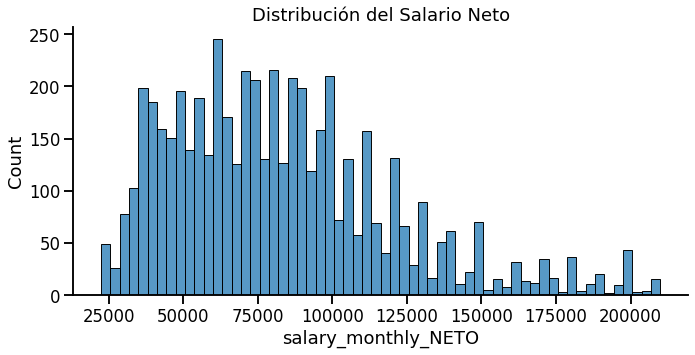

In [ ]:
seaborn.displot(filtered_values['salary_monthly_NETO'], aspect=2, bins=60)
## para evitar la notación científica en las etiquetas
plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribución del Salario Neto')


Vamos a curar los datos de la columna lenguajes de programación

In [ ]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
filtered_values.loc[:, 'cured_programming_languages'] = filtered_values.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
filtered_values = filtered_values.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(filtered_values[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
filtered_values[:5]

,programming_language,profile_years_experience,salary_monthly_NETO,tools_programming_languages,salary_in_usd,work_contract_type,profile_gender,cured_programming_languages
0,ninguno,3.0,43000.0,Ninguno,NaN,Full-Time,Mujer,[ninguno]
1,html,5.0,63000.0,"HTML, Javascript, Python",NaN,Full-Time,Hombre,"[html, javascript, python]"
1,javascript,5.0,63000.0,"HTML, Javascript, Python",NaN,Full-Time,Hombre,"[html, javascript, python]"
1,python,5.0,63000.0,"HTML, Javascript, Python",NaN,Full-Time,Hombre,"[html, javascript, python]"
2,ninguno,2.0,127000.0,Ninguno,NaN,Full-Time,Mujer,[ninguno]


In [ ]:
language_count = filtered_values.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})

Graficamos y analizamos la frecuencia en que aparecen los lenguajes de programación en el set de datos y luego seleccionar aquellos que se presenten en mayor frecuencia.
Observamos que al rededor del 25% de los lenguajes, tenian una frecuencia relevante para analizar.




In [ ]:
max_index = int(len(language_count)/4)
filtered_languages = language_count[0:max_index]

In [ ]:
languages_to_remove = ['ninguno', 'no', '/']
filtered_languages = filtered_languages[ ~filtered_languages['language'].isin(languages_to_remove) ]

In [ ]:
filtered_languages[:45]

,language,frequency
0,javascript,2138
1,sql,1897
2,html,1603
3,java,1278
4,python,1261
5,css,1074
6,bash/shell,878
7,php,766
8,.net,717
9,typescript,655


Text(0.5, 1.0, 'Frecuencia del 25% de lenguajes más utilizados')

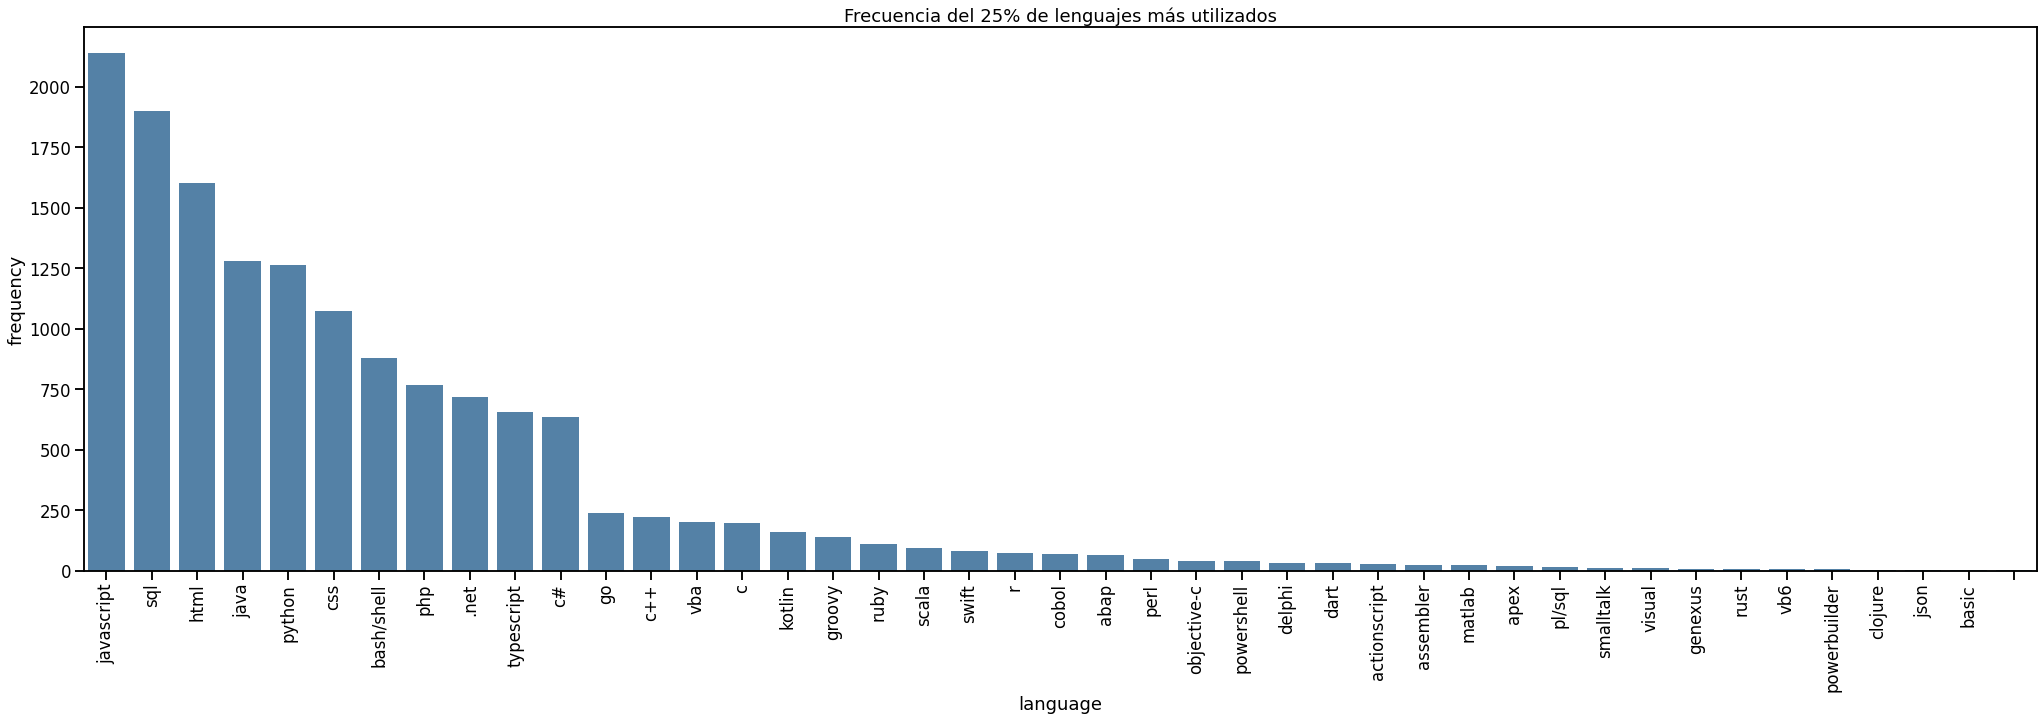

In [ ]:
fig=plt.figure(figsize=(35,10))
seaborn.barplot(data=filtered_languages, x='language', y='frequency', color="steelblue")
plt.xticks(rotation=90);
plt.title('Frecuencia del 25% de lenguajes más utilizados')

Elegimos los primeros 15 lenguajes de mayor frecuencia para analizar. 

In [ ]:
filtered_values = filtered_values[filtered_values['programming_language'].isin(filtered_languages['language'])]

salary_monthly_NETO    80000.0
dtype: float64


Text(0.5, 1.0, 'Mediana de los salarios de los 15 lenguajes más frecuentes')

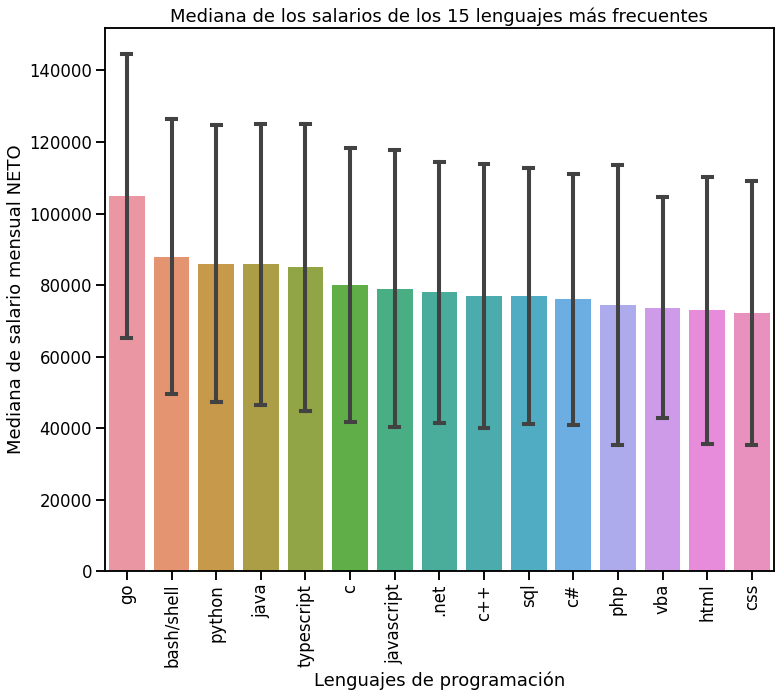

In [ ]:
popular_languages = filtered_languages [:15] ['language'].values.tolist()
small_dataframe = filtered_values[filtered_values['programming_language'].isin(popular_languages)]
programming_languages_salariesdf= small_dataframe[['salary_monthly_NETO','programming_language']]
print(programming_languages_salariesdf.median().sort_values()) 

new_dataframe = small_dataframe[["salary_monthly_NETO", "programming_language"]]
grouped_salaries = new_dataframe.groupby(['programming_language']).median()
ordered_salaries = grouped_salaries.sort_values(["salary_monthly_NETO"], ascending=False)
programming_languages_list = ordered_salaries.index.tolist()

fig = plt.figure(figsize=(12,10))
seaborn.barplot(y=small_dataframe['salary_monthly_NETO'],
                x=small_dataframe['programming_language'],
                estimator=numpy.median, ci="sd",capsize=.2,
                order=programming_languages_list)
plt.xticks(rotation=90)
plt.ylabel("Mediana de salario mensual NETO")
plt.xlabel("Lenguajes de programación")
plt.ticklabel_format(style='plain', axis='y')

plt.title('Mediana de los salarios de los 15 lenguajes más frecuentes')


Utilizamos la mediana para graficar el Salario neto, dado que todos los  lenguajes registran datos en los extremos que afectan la media.

In [ ]:
filtered_values['salary_monthly_NETO'].describe().round()

count     14945.0
mean      85620.0
std       38650.0
min       22500.0
25%       56000.0
50%       80000.0
75%      105000.0
max      210000.0
Name: salary_monthly_NETO, dtype: float64

Text(0.5, 1.0, 'Boxplot de los Salarios de los 15 lenguajes más frecuentes')

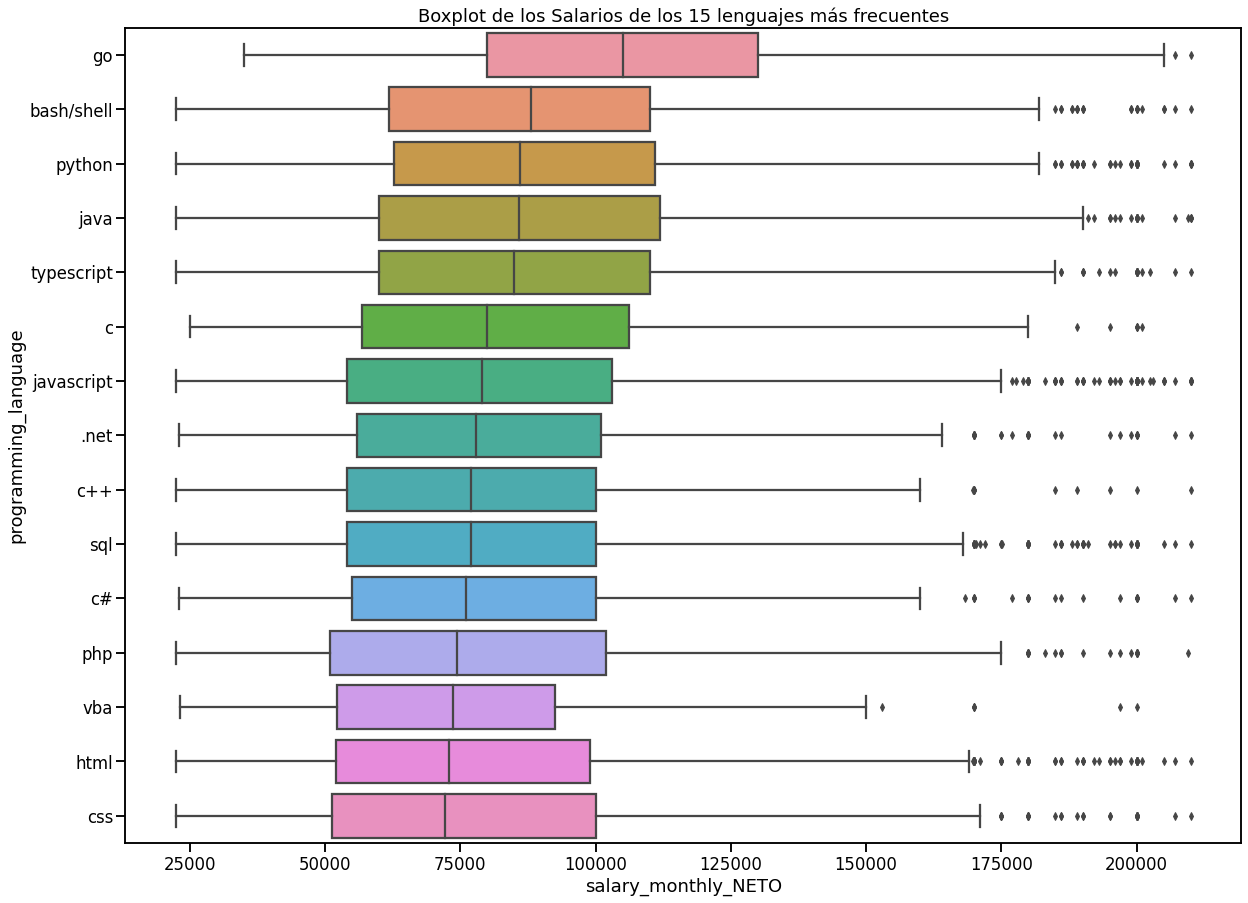

In [ ]:
plt.figure(figsize=(20,15))
seaborn.boxplot(data=new_dataframe, x='salary_monthly_NETO',y='programming_language', order=programming_languages_list)
plt.title('Boxplot de los Salarios de los 15 lenguajes más frecuentes')


Se puede observar que los programadores de go tienen un mayor piso y techo salarial respecto a otros programadores, Q1 se encuentra cercano a los 75 mil pesos y Q3 cercanos a los 130 mil pesos . Por otro lado los programadores de vba tiene menos diferencia entre su piso y techo salarial y más agrupados los datos entre Q1 y Q3.  Lo demas salarios tiene una distribución más homogenea. 



In [ ]:
new_dataframe[new_dataframe['programming_language'] == 'go'].quantile([0.25, 0.75])


,salary_monthly_NETO
0.25,80000.0
0.75,130000.0


In [ ]:
new_dataframe[new_dataframe['programming_language'] == 'vba'].quantile([0.25, 0.75])

,salary_monthly_NETO
0.25,52250.0
0.75,92500.0


Queremos analizar si la experiencia es una variable que influye en el salario neto. Para ello categorizamos los años de experiencia en Senior (mayor 10 años de experiencia), Semisenior (Entre 5 y 10 años de experiencia) y junior (menor de 5 años).

In [ ]:
def set_profile_category(years_of_experience):
    if not isinstance(years_of_experience, float):
        return 'Junior'
    if years_of_experience < 5:
        return 'Junior'
    if years_of_experience < 10:
        return 'Semi Senior'
    return 'Senior'

# Create a new column with the list of languages
filtered_values.loc[:, 'profile_category'] = filtered_values.profile_years_experience\
    .apply(set_profile_category)
filtered_values[:20]

,programming_language,profile_years_experience,salary_monthly_NETO,tools_programming_languages,salary_in_usd,work_contract_type,profile_gender,cured_programming_languages,profile_category
1,html,5.0,63000.0,"HTML, Javascript, Python",NaN,Full-Time,Hombre,"[html, javascript, python]",Semi Senior
1,javascript,5.0,63000.0,"HTML, Javascript, Python",NaN,Full-Time,Hombre,"[html, javascript, python]",Semi Senior
1,python,5.0,63000.0,"HTML, Javascript, Python",NaN,Full-Time,Hombre,"[html, javascript, python]",Semi Senior
3,bash/shell,15.0,102000.0,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",NaN,Full-Time,Hombre,"[bash/shell, c, css, html, java, javascript, p...",Senior
3,c,15.0,102000.0,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",NaN,Full-Time,Hombre,"[bash/shell, c, css, html, java, javascript, p...",Senior
3,css,15.0,102000.0,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",NaN,Full-Time,Hombre,"[bash/shell, c, css, html, java, javascript, p...",Senior
3,html,15.0,102000.0,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",NaN,Full-Time,Hombre,"[bash/shell, c, css, html, java, javascript, p...",Senior
3,java,15.0,102000.0,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",NaN,Full-Time,Hombre,"[bash/shell, c, css, html, java, javascript, p...",Senior
3,javascript,15.0,102000.0,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",NaN,Full-Time,Hombre,"[bash/shell, c, css, html, java, javascript, p...",Senior
3,php,15.0,102000.0,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",NaN,Full-Time,Hombre,"[bash/shell, c, css, html, java, javascript, p...",Senior


Text(0.5, 1.0, 'Mediana salarial según lenguanje y categoría ')

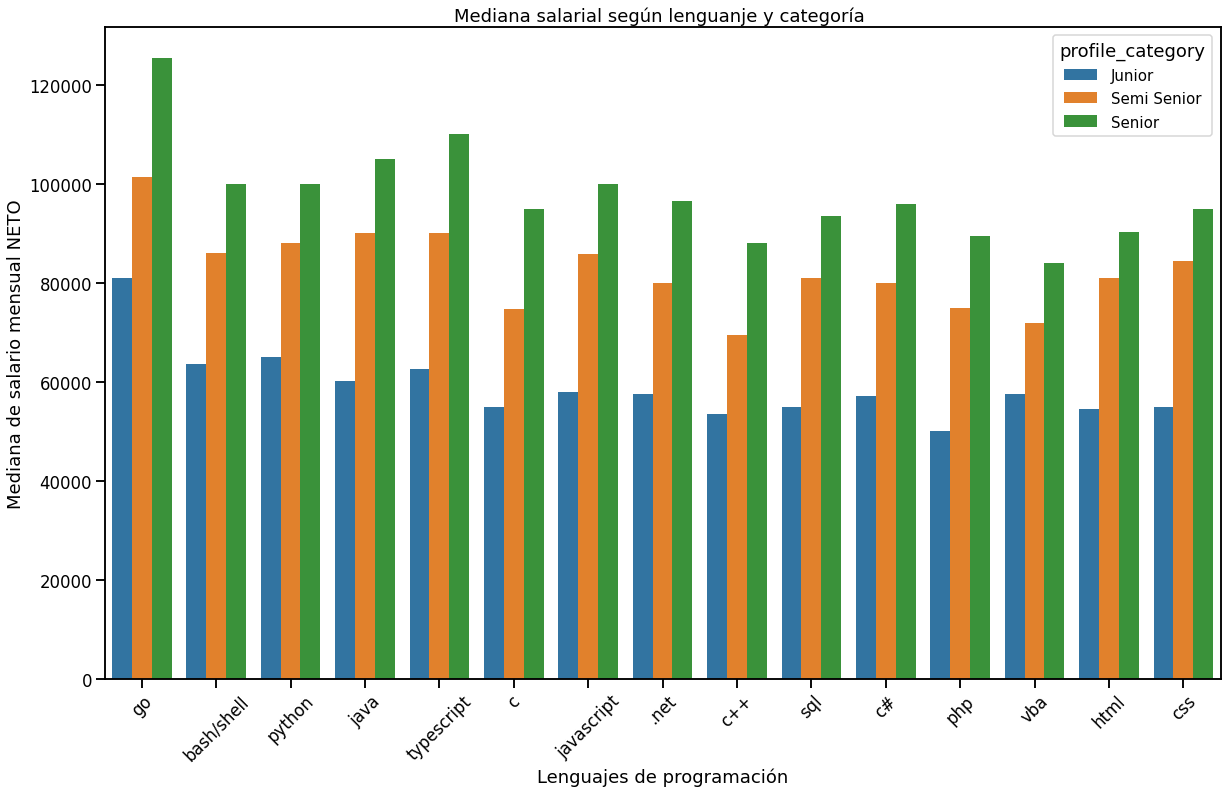

In [ ]:

popular_languages = filtered_languages [:15] ['language'].values.tolist()
small_dataframe = filtered_values[filtered_values['programming_language'].isin(popular_languages)]
small_dataframe.groupby(['salary_in_usd', 'programming_language', 'profile_category']).count()[:40]
fig = plt.figure(figsize=(20,12))

theplot=seaborn.barplot(y=small_dataframe['salary_monthly_NETO'],
                x=small_dataframe['programming_language'],
                hue=small_dataframe['profile_category'],
                estimator=numpy.median, ci=None,
                order=programming_languages_list,
                hue_order=["Junior", "Semi Senior", "Senior"]
                )
plt.xticks(rotation=45)
plt.ylabel("Mediana de salario mensual NETO")
plt.xlabel("Lenguajes de programación")
plt.ticklabel_format(style='plain', axis='y')
plt.setp(theplot.get_legend().get_texts(), fontsize='15')  

plt.title('Mediana salarial según lenguanje y categoría ')



[Text(0.5, 0, 'Salario Mensual Neto')]

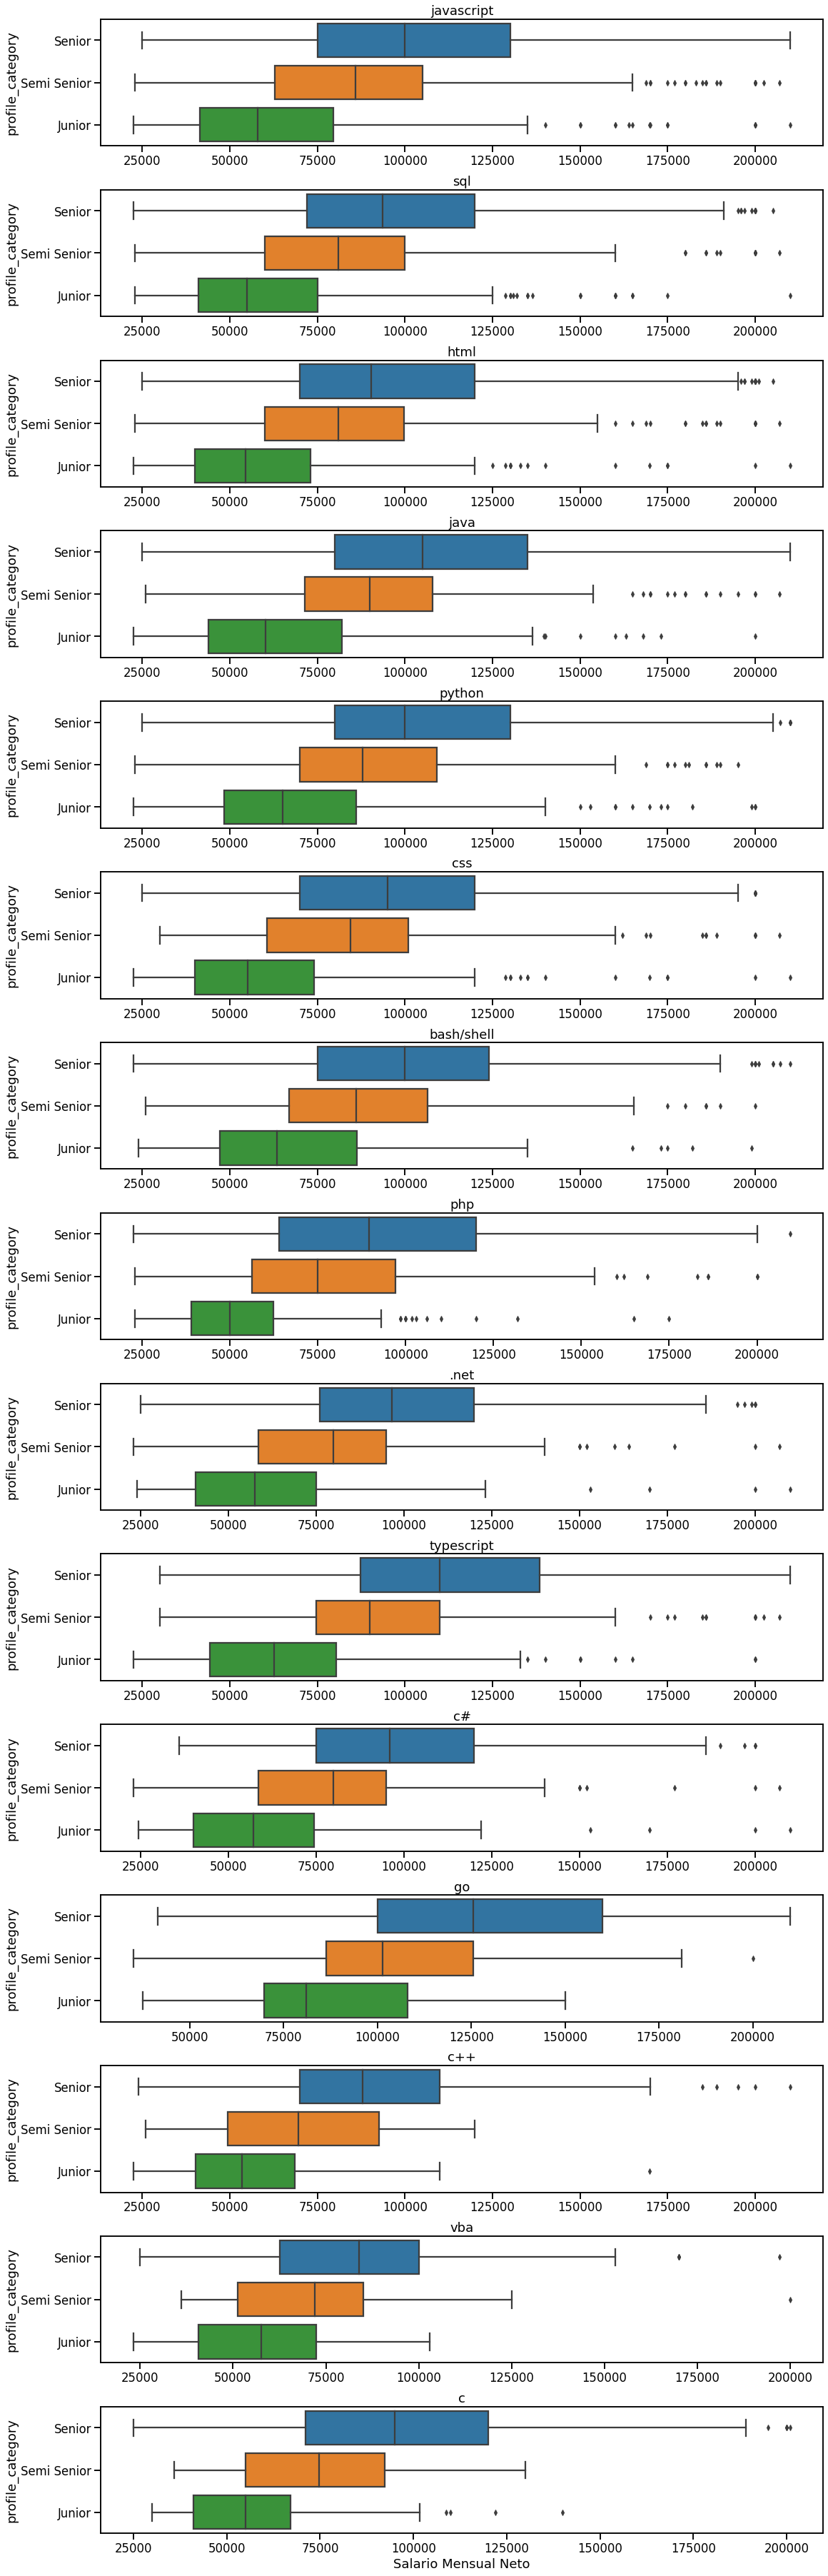

In [ ]:
fig, axes = plt.subplots(nrows=len(popular_languages), figsize=(16, 50), constrained_layout=True)

for index, language in enumerate(popular_languages):
    filtered_data_in_lang = small_dataframe[small_dataframe.programming_language.isin([language])]
    axes[index].set_title(label=popular_languages[index])
    data = small_dataframe[small_dataframe['programming_language'] == language]
    new_boxplot= seaborn.boxplot(data=data, x="salary_monthly_NETO", y="profile_category", order=["Senior", "Semi Senior", "Junior"], ax=axes[index])
    new_boxplot.set(xlabel=None)
new_boxplot.set(xlabel='Salario Mensual Neto')

### Observaciones
* Se observa una tendencia común para todos los lenguajes: los juniors cobran menos que los semiseniors,  y los seniors son los que más cobran. Como primera conclusión podemos decir que la variable **profile_category** afecta al salario.
* Los seniors parecen tener mas dispersión que todos los demás debido a que ocupan casi todo el eje de las X.
* De los lenguajes que seleccionamos, podemos decir que **Go** es uno de los lenguajes mejor pagos, en segundo lugar se encuentra  **Typescrip** y en tercer lugar estarían los programadores de **Java**.

**Aclaración**: Cuando se grafica por categoria, Años de experiencia, el orden de las medianas de salario de los distintos lenguajes cambia, ahora en segundo lugar aparece typescript en lugar de bash/shell. 

In [ ]:
results = small_dataframe.groupby(['programming_language', 'profile_category']).median()[:40]
results.sort_values(by=['profile_category', 'salary_monthly_NETO'], ascending=[True, False])

#for index, profile_category in enumerate(["Junior", "Semi Senior", "Senior"]):
#    print("Ranking de {}".format(profile_category))
#    results.

,,profile_years_experience,salary_monthly_NETO
programming_language,profile_category,,
go,Junior,3.0,81000.00
python,Junior,2.0,65000.00
bash/shell,Junior,2.0,63540.00
typescript,Junior,2.0,62558.00
java,Junior,2.0,60230.00
javascript,Junior,2.0,57967.00
.net,Junior,2.0,57485.00
c#,Junior,2.2,57150.00
css,Junior,2.0,55022.36


Tabla de Medianas Salariales ordenado de mayor a menor por categoría de cada **lenguaje de programación**

---



## Trabajo práctico entregable - Parte 2

<Figure size 2160x2160 with 0 Axes>

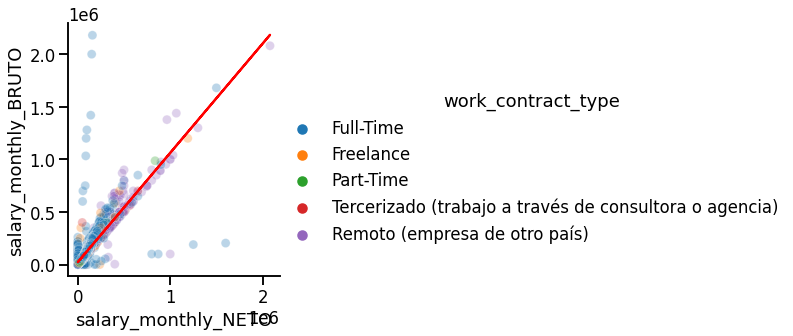

In [ ]:
#Agregar al small dataframe el salario Bruto y el profile gender

from sklearn.linear_model import LinearRegression

data = small_dataframe[small_dataframe['programming_language'] == language]
fig = plt.figure(figsize=(30,30))
tips = seaborn.load_dataset("tips")
work_contract_types_to_include=[]
work_contract_types_to_include+=['Full-Time']
work_contract_types_to_include+=['Freelance']
work_contract_types_to_include+=['Part-Time']
work_contract_types_to_include+=['Tercerizado (trabajo a través de consultora o agencia)']
work_contract_types_to_include+=['Remoto (empresa de otro país)']
filtered_df2=df[df['work_contract_type'].isin(work_contract_types_to_include)]

datos_con_salario_bruto_y_neto = filtered_df2[filtered_df2[["salary_monthly_NETO", "salary_monthly_BRUTO"]].notnull().all(1)]

valores_netos_filtrados = datos_con_salario_bruto_y_neto["salary_monthly_NETO"].values
valores_brutos_filtrados = datos_con_salario_bruto_y_neto["salary_monthly_BRUTO"].values
X = valores_netos_filtrados.reshape(-1, 1)
Y = valores_brutos_filtrados.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

seaborn.relplot(x="salary_monthly_NETO", 
                y="salary_monthly_BRUTO", 
                hue='work_contract_type',
                alpha=.3,
                data=filtered_df2);
plt.plot(X, Y_pred, color='red')

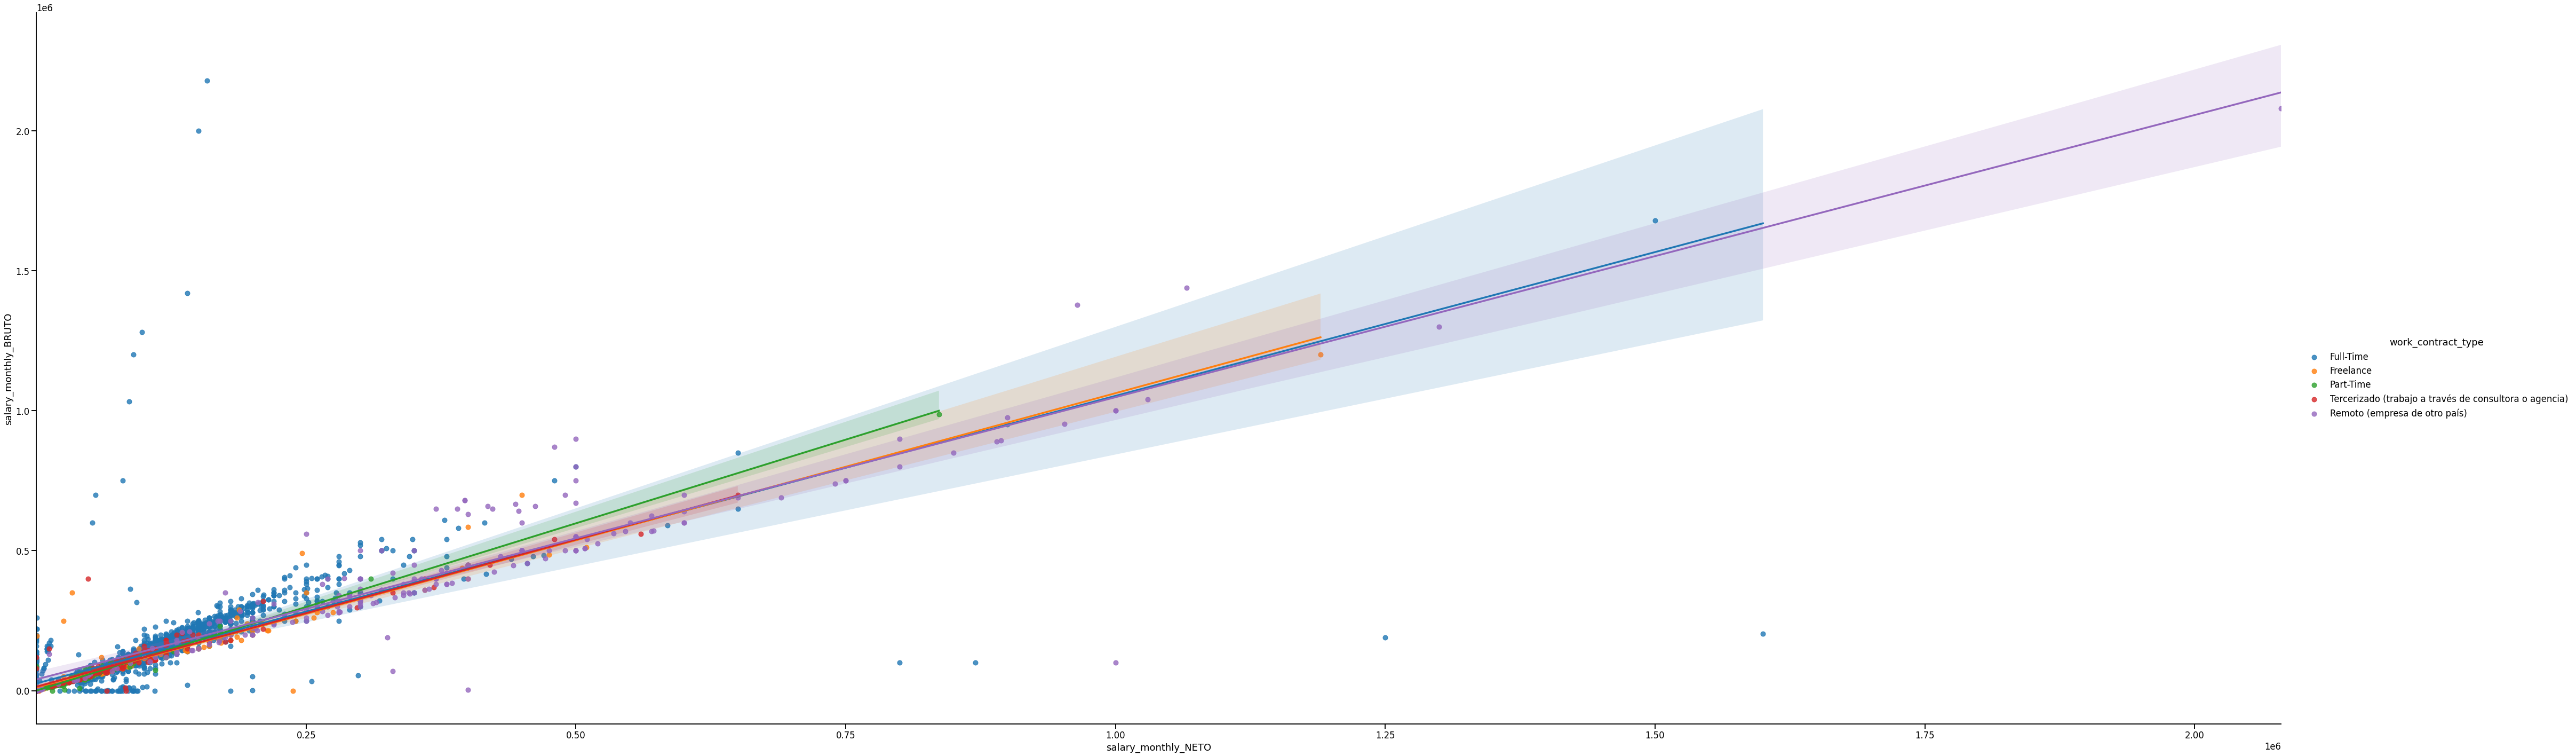

In [ ]:
from sklearn.linear_model import LinearRegression

data = small_dataframe[small_dataframe['programming_language'] == language]
tips = seaborn.load_dataset("tips")
work_contract_types_to_include=[]
work_contract_types_to_include+=['Full-Time']
work_contract_types_to_include+=['Freelance']
work_contract_types_to_include+=['Part-Time']
work_contract_types_to_include+=['Tercerizado (trabajo a través de consultora o agencia)']
work_contract_types_to_include+=['Remoto (empresa de otro país)']
filtered_df2=df[df['work_contract_type'].isin(work_contract_types_to_include)]

datos_con_salario_bruto_y_neto = filtered_df2[filtered_df2[["salary_monthly_NETO", "salary_monthly_BRUTO"]].notnull().all(1)]

valores_netos_filtrados = datos_con_salario_bruto_y_neto["salary_monthly_NETO"].values
valores_brutos_filtrados = datos_con_salario_bruto_y_neto["salary_monthly_BRUTO"].values

seaborn.lmplot(x="salary_monthly_NETO", 
                y="salary_monthly_BRUTO", 
                data=filtered_df2,
                hue='work_contract_type',
               height = 20, aspect = 3)


Para analizar la posible correlación, tomamos una grafica pertienente al mismo, donde se observa que los datos se agrupan:
1. Primer grupo: tienen salarios brutos y netos que guardan relación lineal. Se encuntra el mayor volumen de datos, lo que nos permite suponer que se guarda correlación entre ambos salarios. Se puede concluir tambien que se guarda correlación para todos los tipos de contrato de trabajo
2. Segundo grupo tiene el salio bruto mayor al neto.
3. Tercer grupo tienen salarios netos mayores que los brutos.
La cantidad de  casos del segundo y tercer grupos, consideremos no significante. 



## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






Las columnas de interes son 'profile_studies_level' y 'salary_monthly_NETO'
sino ver: 'profile_studies_level_state''salary_monthly_BRUTO'

In [ ]:
filtered_values = df[df['salary_monthly_NETO'].notnull()]


interesting_range = filtered_values['salary_monthly_NETO'].quantile([.05, .95])
min = interesting_range.values[0]
max = interesting_range.values[1]
filtered_values = filtered_values[filtered_values['salary_monthly_NETO'].between(min, max)]


In [ ]:
datauniv = filtered_values[filtered_values['profile_studies_level'] == 'Universitario']
dataterciario = filtered_values[filtered_values['profile_studies_level'] == 'Terciario']

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable 'salary_monthly_NETO'

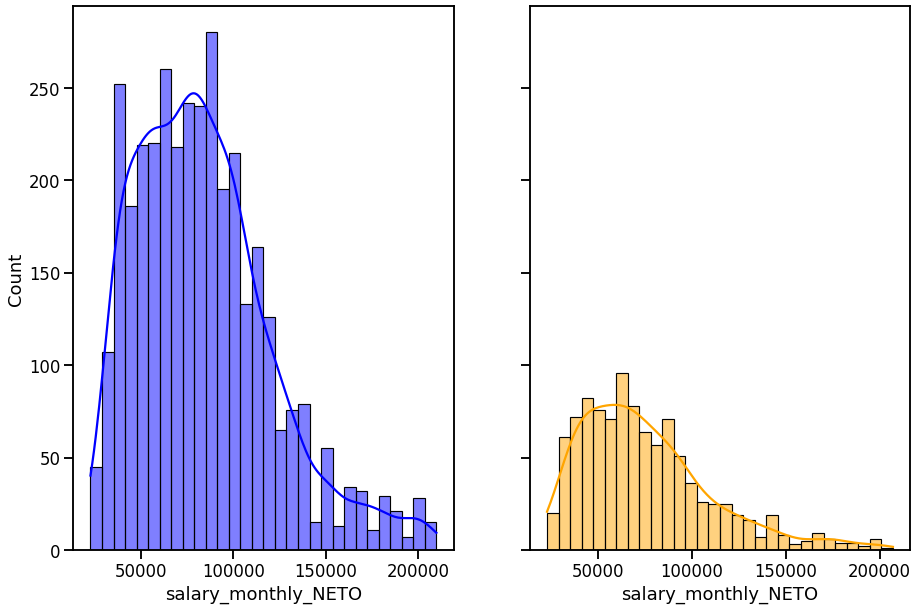

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,10),sharey='row')

seaborn.histplot(datauniv["salary_monthly_NETO"], ax=ax[0],
                 stat='count',bins=30, kde=True, color='BLUE')

seaborn.histplot(dataterciario["salary_monthly_NETO"], ax=ax[1],
                  stat='count', bins=30, kde=True, color='ORANGE')
#plt.title()
fig.show()


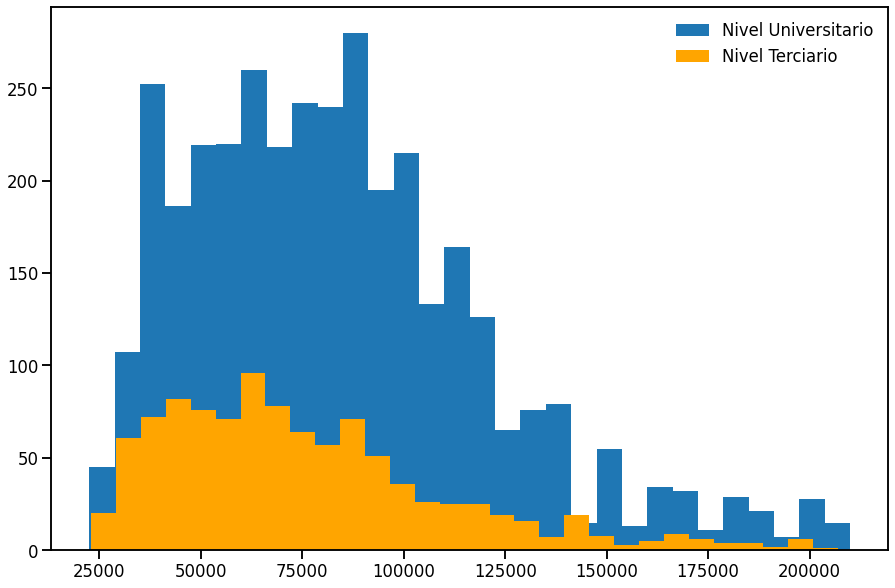

In [ ]:
fig=plt.figure(figsize=(15,10))
plt.hist(datauniv['salary_monthly_NETO'], bins=30,label='Nivel Universitario')
plt.hist(dataterciario['salary_monthly_NETO'],bins=30,label='Nivel Terciario', color='ORANGE')
plt.legend(frameon=False, loc='upper right')
plt.show()

c) Densidad condicional
Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable 'salary_monthly_NETO' ¿Considera que ambas variables son independientes? ¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación

Probabilidad de tener un nivel universitario significa mayor salario que el promedio?
Probablidad de tener Posgrado significa mayor salario que el promedio?


In [ ]:
avg_salary= filtered_values['salary_monthly_NETO'].mean()
avg_salary

82649.00899527855

In [ ]:
is_above_avg= filtered_values['salary_monthly_NETO']>= avg_salary
is_above_avg[:10]

0    False
1    False
2     True
3     True
4     True
5    False
6    False
7    False
8    False
9    False
Name: salary_monthly_NETO, dtype: bool

In [ ]:
titulo_univ= filtered_values['profile_studies_level']=='Universitario'
titulo_terciario= filtered_values['profile_studies_level']=='Terciario'

In [ ]:
intersection_count_univ = len(filtered_values[is_above_avg & titulo_univ])
intersection_count_terciario = len(filtered_values[is_above_avg & titulo_terciario])
print(intersection_count_terciario)
print(intersection_count_univ)

353
1648


In [ ]:
p_above_avg_when_univ= (intersection_count_univ/len(titulo_univ))
p_above_avg_when_terciario= (intersection_count_terciario/len(titulo_terciario))

print('p_above_avg_when_univ:', p_above_avg_when_univ)
print('p_above_avg_when_terciario:', p_above_avg_when_terciario)

p_above_avg_when_univ: 0.31123701605288007
p_above_avg_when_terciario: 0.06666666666666667


In [ ]:
p_above_avg = len(filtered_values[filtered_values['salary_monthly_NETO'] >= avg_salary]) / len(filtered_values)
p_above_avg

0.44022662889518416

Graficamos y analizamos el conteo de datos de cada nivel de estudio y elegimos las categorias, universitario y tecerciario que son los tienen mayor cantidad de datos. Luego calculamos la probabilidad condicional entre el saalrio y el nivel de estudio, lo que nos permite concluir que la variable sueldo es dependientes del nivel de estudio.



Medidas de posición

In [ ]:
salario_medio_universitarios = datauniv['salary_monthly_NETO'].mean()
salario_medio_terciario = dataterciario['salary_monthly_NETO'].mean()

Mediana_sal_univ=datauniv['salary_monthly_NETO'].median()
Mediana_sal_terc=dataterciario['salary_monthly_NETO'].median()


print('salario medio Universitarios:', salario_medio_universitarios)
print('salario medio Terciarios:',salario_medio_terciario)

print('mediana salario Universitarios:', Mediana_sal_univ)
print('mediana salario Terciarios:', Mediana_sal_terc)



salario medio Universitarios: 83931.06547738695
salario medio Terciarios: 75478.52470588236
mediana salario Universitarios: 80000.0
mediana salario Terciarios: 69545.5


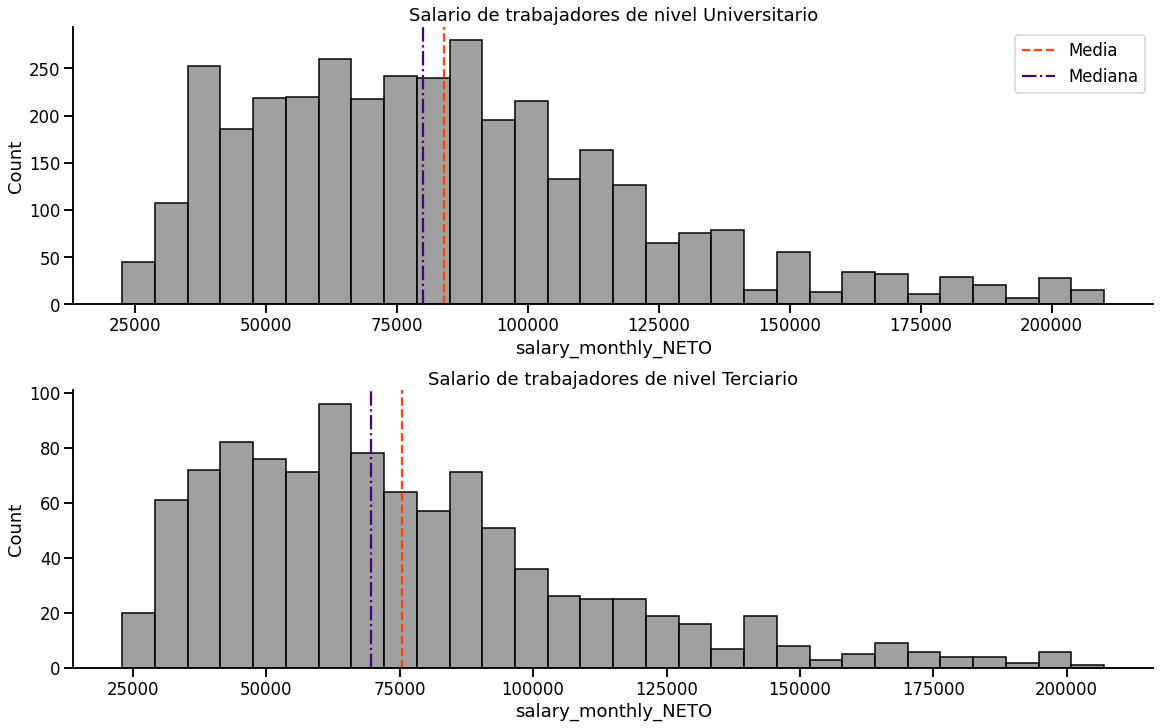

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 10),constrained_layout=True)
seaborn.histplot(datauniv['salary_monthly_NETO'], bins=30, ax=axes[0], color='gray')
axes[0].axvline(datauniv['salary_monthly_NETO'].mean(), color='orangered',
            linestyle='--', label='Media')
axes[0].axvline(datauniv['salary_monthly_NETO'].median(), color='indigo',
            linestyle='-.', label='Mediana')
axes[0].set_title('Salario de trabajadores de nivel Universitario')
#axes[0].set(xlabel=None)

seaborn.histplot(dataterciario['salary_monthly_NETO'], bins=30, ax=axes[1], color='gray')
axes[1].axvline(dataterciario['salary_monthly_NETO'].mean(), color='orangered',
            linestyle='--', label='Media')
axes[1].axvline(dataterciario['salary_monthly_NETO'].median(), color='indigo',
            linestyle='-.', label='Mediana')
axes[1].set_title('Salario de trabajadores de nivel Terciario')

axes[0].legend()
seaborn.despine()

Medidas de Dispersion

In [ ]:
 datauniv['salary_monthly_NETO'].describe().round()

count      3582.0
mean      83931.0
std       37040.0
min       22500.0
25%       55000.0
50%       80000.0
75%      104000.0
max      210000.0
Name: salary_monthly_NETO, dtype: float64

In [ ]:
 dataterciario['salary_monthly_NETO'].describe().round()

count      1020.0
mean      75479.0
std       35120.0
min       22980.0
25%       49800.0
50%       69546.0
75%       93000.0
max      207020.0
Name: salary_monthly_NETO, dtype: float64

Los programadores con estudio universitario tienen mayor salario neto, que se reflejan en una media y mediana que se desplanzan a la derecha, en la distribución de datos, respecto a los programadores con estudios terciarios. 
Si obervamos los valores de la desviación estándar, podemos concluir que en ambos grupos la dispersión es similar.

d) Densidad Conjunta condicional: Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)

In [ ]:
max_profile_years_experience_allowed = filtered_values['profile_years_experience'].quantile([.99]).values[0]
filtered_values = filtered_values[filtered_values['profile_years_experience'] <= max_profile_years_experience_allowed]

In [ ]:
max_profile_years_experience_allowed = filtered_values['profile_age'].quantile([.99]).values[0]
filtered_values = filtered_values[filtered_values['profile_age'] <= max_profile_years_experience_allowed]

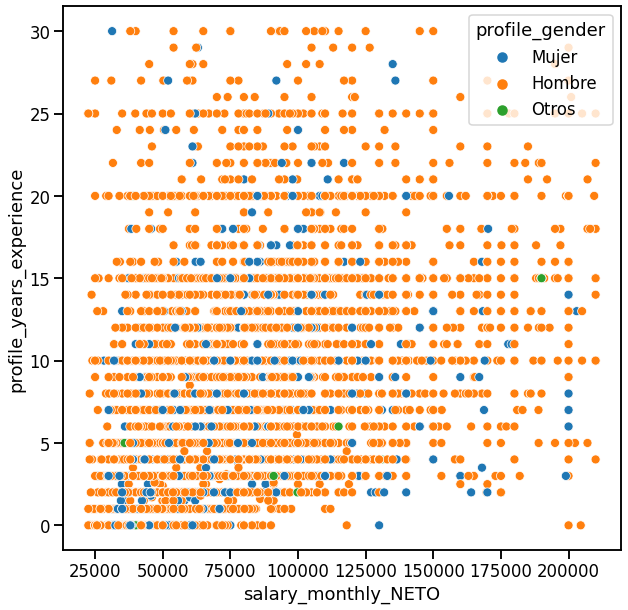

In [ ]:
fig=plt.figure(figsize=(10,10))
seaborn.scatterplot(data=filtered_values, x="salary_monthly_NETO", y="profile_years_experience",hue='profile_gender')

Del siguiente gráfico podemos sacar las siguientes conclusiones:
1. Se observa que la mayor densidad de casos tienen menos de 15 años de experiencia y cobran por debajo de los 135000 pesos.
2. En los casos sin experiencia se obervan mayor cantidad de hombres, que de mujeres. Lo que podria indicar que ingresan mayor cantidad de hombres que de mujeres al rubro.
3. Hay un grupo de casos que superan los 20 años de experiencia y ganan lo mismo que el grupo de menos de 15 años de experiencia.
4. Los casos con salarios mayores a 165000 pesos y más de 20 años de experiencia son hombres.
6. Los casos de generos Otros representan una mínima cantidad de datos y se agrupan por debajo de los 15 años de experiencia, se puede suponer que esto se debe a nuevas politicas dentro de las empresas.
5. Para un análisis más detallado se podria realizar otro tipos de graficas interactivas que permitean seleccionar por género, para apreciar mejor la distribución. 